In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
#I decided to load all of the files then turn them into csvs. I prefer to work with csvs because
#they are more human read-able than JSON. Csvs are also slightly more efficient

df = pd.read_json(r'D:\Code Data\data analytics assignment 3\dblp-ref\dblp-ref-0.json', lines = True)
df.to_csv(r'D:\Code Data\data analytics assignment 3\dblp-ref\dblp-ref-0.csv', index = None)
df = pd.read_json(r'D:\Code Data\data analytics assignment 3\dblp-ref\dblp-ref-1.json', lines = True)
df.to_csv(r'D:\Code Data\data analytics assignment 3\dblp-ref\dblp-ref-1.csv', index = None)
df = pd.read_json(r'D:\Code Data\data analytics assignment 3\dblp-ref\dblp-ref-2.json', lines = True)
df.to_csv(r'D:\Code Data\data analytics assignment 3\dblp-ref\dblp-ref-2.csv', index = None)
df = pd.read_json(r'D:\Code Data\data analytics assignment 3\dblp-ref\dblp-ref-3.json', lines = True)
df.to_csv(r'D:\Code Data\data analytics assignment 3\dblp-ref\dblp-ref-3.csv', index = None)

In [3]:
db0 = pd.read_csv(r'D:\Code Data\data analytics assignment 3\dblp-ref\dblp-ref-0.csv')
db1 = pd.read_csv(r'D:\Code Data\data analytics assignment 3\dblp-ref\dblp-ref-1.csv')
db2 = pd.read_csv(r'D:\Code Data\data analytics assignment 3\dblp-ref\dblp-ref-2.csv')
db3 = pd.read_csv(r'D:\Code Data\data analytics assignment 3\dblp-ref\dblp-ref-3.csv')

In [4]:
#I'm interested in earlier works, so I will cut off all data from after 2005

db0 = db0[(db0["year"]) < 1980]
db1 = db1[(db1["year"]) < 1980]
db2 = db2[(db2["year"]) < 1980]
db3 = db3[(db3["year"]) < 1980]

In [5]:
print(len(db0),len(db1),len(db2),len(db3)) #total length of each filtered dataframe

9075 14151 4056 233


In [8]:
total_dataframe = pd.concat((db0,db1,db2,db3), ignore_index = True)

In [ ]:
total_dataframe.to_csv(r'D:\Code Data\data analytics assignment 3\dblp-ref\total_csv.csv', index = None)

# Alright!
#### Now we're finished all of the boring stuff. We can actually start analyzing the data. I can also start from this block when running the code (after importing the packages, of course).


#### I think I will use a paper as a node, and citation  relationships as edges. I'm less interested in the relationship between authors and references than papers themselves (though, because authors tend to stick to their field, these should not look much different).

In [2]:
df_ = pd.read_csv(r'D:\Code Data\data analytics assignment 3\dblp-ref\total_csv.csv')

#### Looks like our data has some None entries as well as some empty lists. No problem, we can work around that in a function with a couple drops.

In [3]:
Dataframe = pd.DataFrame()
Dataframe['id'] = df_['id']
Dataframe['references'] = df_['references']
Dataframe = Dataframe.dropna()

#graph = nx.from_pandas_edgelist(Dataframe, 'id', 'references', create_using=nx.DiGraph())

In [4]:
id_arr = np.array(Dataframe['id'])
ref_arr = np.array(Dataframe['references'])

In [5]:
#first we create our graph
graph = nx.Graph()
#then we define nodes
for node in id_arr:
    graph.add_node(node)
#that part was easy

#now we define edges
for n in range(len(id_arr)):
    node = id_arr[n]
    edges = ref_arr[n]
    for edge in edges.split(','):
        #there is a lot of messyness. What should be a list of edges come in string
        #format, so we need to split the string then clean up the remaining
        #artifacts of its previous strin format
        edge = edge.strip('[]')
        edge = edge.strip(' ')
        edge = edge.replace("'","")
        
        #now we simply add the edge
        if edge != str(): #band-aid solution to a problem where some edges were empty
            graph.add_edge(node,edge)

#### and now we have our graph!
# Question 2

In [39]:
largest_subgraph = graph.subgraph(max(nx.connected_components(graph.to_undirected()),key = len)).to_undirected()

In [41]:
print(f"diameter: {nx.diameter(largest_subgraph)}")
print(f"radius: {nx.radius(largest_subgraph)}")
print(f"density: {nx.density(graph)}")
print(f"nodes: {len(graph.nodes)}")
print(f"edges: {len(graph.edges)}")
print(f"average degree: {len(graph.nodes)/len(graph.edges)}")

diameter: 27
radius: 14
density: 0.00019369902199160862
nodes: 22910
edges: 50831
average degree: 0.4507092128819028


### Next we will plot our histogram

#### I checked the graph and found that there were many 1 degree points. It looked like it could be a pareto distribution (which would call for a log-log plot), but I decided to check if the distribution was different if I elimnated 1 degree datapoints and plot both.

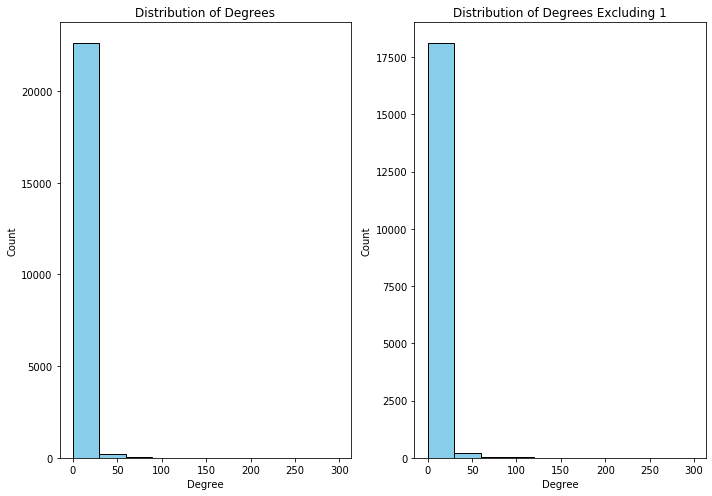

In [8]:
degree_list = []
for degree in list(graph.degree):
    degree_list.append(degree[1]) #appends the degree

degree_not_1 = []
for degree in degree_list:
    if degree != 1: #appends the degree if it isn't 1
        degree_not_1.append(degree)


fig, axs = plt.subplots(1, 2, tight_layout=True)
fig.set_size_inches(10, 7)
# We can set the number of bins with the `bins` kwarg
axs[0].hist(degree_list, color = "skyblue", ec="k")
axs[1].hist(degree_not_1, color = "skyblue", ec="k")
plt.xlabel("Degree")
plt.ylabel("Count")
axs[0].set_title("Distribution of Degrees")
axs[0].set_xlabel("Degree")
axs[0].set_ylabel("Count")
axs[1].set_title("Distribution of Degrees Excluding 1")
axs[1].set_xlabel("Degree")
axs[1].set_ylabel("Count")
plt.show()

### Examining this plot, we can see pretty clearly that we will want a log-log plot. Including 1 degree results in an extreme pareto distribution. I tested to see if removing 1 made the distribution less extreme, but it didn't do so to a degree that I found satisfying.

In [9]:
#I needed to make this because some degrees were 0, which caused me to get -inf,
#which obviously doesn't plot very well
def zero_or_log(list_):
    all_vals = []
    for val in list_:
        if val == 0:
            all_vals.append(0)
        else:
            all_vals.append(np.log(val))
    return all_vals

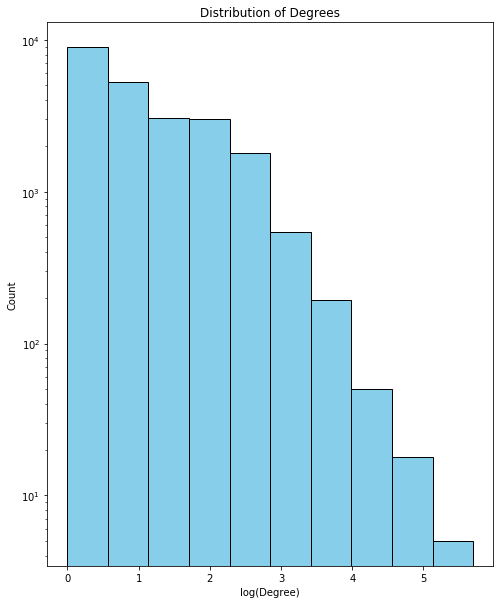

In [10]:
plt.figure(figsize=(8, 10))
# We can set the number of bins with the `bins` kwarg
plt.hist(zero_or_log(degree_list),log = True, color = "skyblue", ec="k")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Distribution of Degrees")
plt.xlabel("log(Degree)")
plt.ylabel("Count")
plt.show()

## This histogram is looking much more linear.

In [11]:
degree_centrality = nx.degree_centrality(graph)

In [12]:
centrality_values = list(degree_centrality.values())
id_ = list(degree_centrality.keys())

In [13]:
print("Here is our most central node ",id_[0])

Here is our most central node  04f16960-42b0-4f58-a1ff-23844582c40c


In [14]:
max_id = id_[centrality_values.index(max(centrality_values))]
print("The paper which has the highest degreee centrality has the ID ",max_id, "and it has a"
      ,"degree centrality of ",degree_centrality[max_id])

The paper which has the highest degreee centrality has the ID  e930195e-baa4-4d42-9d5f-e042fcaf5a9e and it has a degree centrality of  0.013007988126937011


#### I am going to do this for the top 5.

In [15]:
max_vals = []
for n in range(5):
    centrality_values = list(degree_centrality.values())
    id_ = list(degree_centrality.keys())
    max_n = centrality_values.index(max(centrality_values))
    max_id_n = id_[max_n]
    del degree_centrality[max_id_n]
    max_vals.append(max_id_n)
    
degree_centrality = nx.degree_centrality(graph)

In [16]:
print("these are the top five centrality values")
nodes = len(graph.nodes)
for n in range(5):
    print(degree_centrality[max_vals[n]], "which is ",int(nodes*degree_centrality[max_vals[n]]),
          "connections. This is attributed to the paper ID ",max_vals[n])

these are the top five centrality values
0.013007988126937011 which is  298 connections. This is attributed to the paper ID  e930195e-baa4-4d42-9d5f-e042fcaf5a9e
0.012484176524510017 which is  286 connections. This is attributed to the paper ID  fa0b4274-c58c-464c-9e29-dc87e62b414f
0.01187306298834519 which is  272 connections. This is attributed to the paper ID  a662a4e7-415e-417e-8a8f-fe085d7e487f
0.00859924047317648 which is  197 connections. This is attributed to the paper ID  172f9f68-8417-43bb-8fe5-b377d569f6b6
0.00746431533458466 which is  171 connections. This is attributed to the paper ID  b0f6455a-6f99-42c5-8502-4fa535768ceb


In [17]:
#let's just do a quick check
print("This value should be equal to 286:",len(graph['fa0b4274-c58c-464c-9e29-dc87e62b414f']))

This value should be equal to 286: 286


#### Looks good. Let's take a look at the betweenness of these nodes. I would suspect highly central nodes to be somewhat well connected. I'll compare the betweenness of these nodes to the betweenness of 5 random nodes

In [18]:
node_list = list(graph.nodes)
import random as rd #for random index vals

random_nodes = []
for n in range(5):
    rand = rd.randint(0,len(node_list))
    random_nodes.append(node_list[rand]) #appends random node
    

for n in range(5):
    id_ = max_vals[n]
    temp_other_ids = max_vals[0:n]+max_vals[n+1:] #removes element from list without mutation
    print("betweenness of highly_central node: ",round(sum((nx.betweenness_centrality_subset(graph,[id_],temp_other_ids)).values())))   #so we can make use of same list later
    print("betweenness of highly_central node with random nodes: ",round(sum((nx.betweenness_centrality_subset(graph,[id_],random_nodes)).values())))

betweenness of highly_central node:  3
betweenness of highly_central node with random nodes:  6
betweenness of highly_central node:  2
betweenness of highly_central node with random nodes:  4
betweenness of highly_central node:  2
betweenness of highly_central node with random nodes:  4
betweenness of highly_central node:  2
betweenness of highly_central node with random nodes:  5
betweenness of highly_central node:  3
betweenness of highly_central node with random nodes:  4


#### The betweenness of highly central nodes is typically lower than random nodes. This means that the paths of a highly central node to other highly central nodes is less likely to require an intermediate node. In other words, the highly central nodes are less likely have other nodes betwen them and are thus "closer" together.


#### Next, I am going to do an eigenvector centrality analysis. This allows us to get (what I think is) a more honest look at the relevance of a node. I would expect to see a similar distribution to the degree centrality analysis, but we may see different nodes at the top. We will take a look at the top five from degree centrality and the top five from eigenvector centrality and compare their IDs.

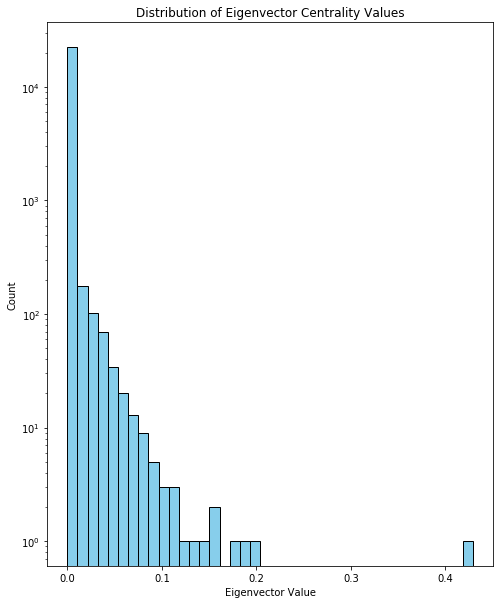

In [19]:
eigenvec_cen = (nx.eigenvector_centrality(graph)).values()

plt.figure(figsize=(8, 10))
# We can set the number of bins with the `bins` kwarg
plt.hist(eigenvec_cen,log = True,bins = 40, color = "skyblue", ec="k")
plt.title("Distribution of Eigenvector Centrality Values")
plt.xlabel("Eigenvector Value")
plt.ylabel("Count")
plt.show()

In [20]:
eigenvec_cen = nx.eigenvector_centrality(graph)

eigen_max_vals = []
for n in range(5):
    eigen_centrality_values = list(eigenvec_cen.values())
    id_ = list(eigenvec_cen.keys())
    max_n = eigen_centrality_values.index(max(eigen_centrality_values))
    eigen_max_id_n = id_[max_n]
    del eigenvec_cen[eigen_max_id_n]
    eigen_max_vals.append(eigen_max_id_n)
    
eigenvec_cen = nx.eigenvector_centrality(graph)

In [21]:
for n in range(5):
    print("Eigenvalue centrality values: ",eigen_max_vals[n],"Degree centrality values: ",max_vals[n])

Eigenvalue centrality values:  e930195e-baa4-4d42-9d5f-e042fcaf5a9e Degree centrality values:  e930195e-baa4-4d42-9d5f-e042fcaf5a9e
Eigenvalue centrality values:  5e1ee9bb-e5dc-4617-8f6a-027698a729a7 Degree centrality values:  fa0b4274-c58c-464c-9e29-dc87e62b414f
Eigenvalue centrality values:  591bf46d-f30f-488c-8ebc-da7809bee7a7 Degree centrality values:  a662a4e7-415e-417e-8a8f-fe085d7e487f
Eigenvalue centrality values:  a2d095fb-cb2c-4658-9156-85a7e5953082 Degree centrality values:  172f9f68-8417-43bb-8fe5-b377d569f6b6
Eigenvalue centrality values:  f6712eb3-d0a1-4fe3-8737-2b0c2166922f Degree centrality values:  b0f6455a-6f99-42c5-8502-4fa535768ceb


#### As we can see, the node with the highest degree centrality also has the highest eigenvalue centrality. This must be a very important paper, so I decided to find out what it is. I checked the dataset and found that this highly important paper is written by Edgar F. Codd, a computer scientist who invented the relational model for database management. He is referred to as "the father of the database". Clearly a very important man. The paper in question is titled  "A relational model of data for large shared data banks" (the paper which earned him this nickname). The paper is cited 12,612 times. This is certainly a success in centrality analysis.




The following unsupervied learning link prediction is largely based on the example given in the following link: https://github.com/lucashu1/link-prediction/blob/257604029069ba7baf6692e3839aa863bef22b06/link-prediction-baselines.ipynb

In [22]:

from sklearn.metrics import  roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

In [23]:
from gae.preprocessing import mask_test_edges
np.random.seed(0) # make sure train-test split is consistent between notebooks
adj_sparse = nx.to_scipy_sparse_matrix(graph)

# Perform train-test split
adj_train, train_edges, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse)
g_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges

In [24]:
# Inspect train/test split
print("Total nodes:", adj_sparse.shape[0])
print("Total edges:", int(adj_sparse.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print("Training edges (positive):", len(train_edges))
#print("Training edges (negative):", len(train_edges_false))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 22910
Total edges: 50831
Training edges (positive): 43207
Validation edges (positive): 2541
Validation edges (negative): 2541
Test edges (positive): 5083
Test edges (negative): 5083


In [25]:
def get_roc_score(edges_pos, edges_neg, score_matrix):
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(score_matrix[edge[0], edge[1]]) # predicted score
        pos.append(adj_sparse[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(score_matrix[edge[0], edge[1]]) # predicted score
        neg.append(adj_sparse[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

In [26]:
# Compute Adamic-Adar indexes from g_train
aa_matrix = np.zeros(adj_sparse.shape)
for u, v, p in nx.adamic_adar_index(g_train): # (u, v) = node indices, p = Adamic-Adar index
    aa_matrix[u][v] = p
    aa_matrix[v][u] = p # make sure it's symmetric
    
# Normalize array
aa_matrix = aa_matrix / aa_matrix.max()

In [27]:
# Calculate ROC AUC and Average Precision
aa_roc, aa_ap = get_roc_score(test_edges, test_edges_false, aa_matrix)

print('Adamic-Adar Test ROC score: ', str(aa_roc))
print('Adamic-Adar Test AP score: ', str(aa_ap))

Adamic-Adar Test ROC score:  0.7856022255620637
Adamic-Adar Test AP score:  0.7857207434347913


#### We have a pretty good accuracy with the unsupervised learning. We will now try a supervised learning approach and compare the accuracy.


#### I had a very hard time getting the unsupervised learning to work. I found that many packages had outdated or confusing documentation, but ended up finding that the stellargraph docs had a good example for supervised learning. The following code is largely based on the example from the following stellargraph docs example:
https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/node2vec-link-prediction.ipynb#scrollTo=S6PLleHttlBl

In [28]:
from stellargraph import StellarGraph


from stellargraph.data import EdgeSplitter


In [29]:
stellar_graph = StellarGraph(graph)
stellar_graph.info()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  """Entry point for launching an IPython kernel.


'StellarGraph: Undirected multigraph\n Nodes: 22910, Edges: 50831\n\n Node types:\n  default: [22910]\n    Features: none\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [50831]\n        Weights: all 1 (default)\n        Features: none'

In [30]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(stellar_graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())

** Sampled 5083 positive and 5083 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 22910, Edges: 45748

 Node types:
  default: [22910]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [45748]
        Weights: all 1 (default)
        Features: none


In [31]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, stellar_graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 4574 positive and 4574 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 22910, Edges: 41174

 Node types:
  default: [22910]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [41174]
        Weights: all 1 (default)
        Features: none


In [32]:
#prints our testing and training data makeup
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,6861,Train Graph,Test Graph,Train the Link Classifier
Model Selection,2287,Train Graph,Test Graph,Select the best Link Classifier model
Test set,10166,Test Graph,Full Graph,Evaluate the best Link Classifier


In [33]:
p = 1.0
q = 1.0
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = 1

In [34]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec

#creates walks and runs Word2Vec
def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(stellar_graph)
    walks = rw.run(stellar_graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        epochs=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

D:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [35]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 229100


In [36]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="average_precision", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [37]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [38]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "Average Precision score"),
).set_index("name")

Best result from 'operator_hadamard'


,Average Precision score
name,
operator_hadamard,0.997994
operator_l1,0.960817
operator_l2,0.960972
operator_avg,0.776850


#### We find that the supervised learning link predictor is far superior to the unsupervised link predictor if we make use of the Hadamard operator.